# ts_aos_analysis

# AOS  DM-46763:  WET-007 Compare CWFS approaches with WET-001 ComCam data

Use WET-001 LsstComCam data. As for LsstCam, it is a simulation of 100 random states, with intra, extra, and in-focus positions.  


# Employ the central butler repository  to ingest raws,  perform ISR, and run WEP.

In [ ]:
butler register-instrument /sdf/data/rubin/repo/aos_imsim lsst.obs.lsst.LsstComCam 

In [2]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
outputImgDir = (
    "/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state*"
)

butlerInstName = "Cam"
cmd4 = f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"
print(cmd4, "\n")

butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state*/amp* 



In [ ]:
Run 

    butler write-curated-calibrations /sdf/data/rubin/repo/aos_imsim  lsst.obs.lsst.LsstComCam 


Running

    butler define-visits /sdf/data/rubin/repo/aos_imsim   lsst.obs.lsst.LsstComCam

yields 

    lsst.defineVisits INFO: Preprocessing data IDs.
    lsst.defineVisits INFO: Registering visit_system 0: one-to-one.
    lsst.defineVisits INFO: Registering visit_system 2: by-seq-start-end.
    lsst.defineVisits INFO: Grouping 300 exposure(s) into visits.
    lsst.defineVisits INFO: Computing regions and other metadata for 300 visit(s).


which makes sense, because we have 3 focusZ positions (intra/extra/in-focus),  with 100 states each.  

In   `cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007`,  make `site_bps.yaml`, containing  


    site:
      s3df:
        profile:
          condor:
            +Walltime: 7200

In [15]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCam/raw/all'],
                             where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 and exposure.science_program = '1'").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)
#print(len(refs)

2640


Ok, so that's a lot of refs.  Show the first one:

In [10]:
ref.dataId.detector

detector.RecordClass(instrument='LSSTComCam', id=4, full_name='R22_S11', name_in_raft='S11', raft='R22', purpose='SCIENCE')

In [16]:
ref.dataId.exposure

exposure.RecordClass(instrument='LSSTComCam', id=5024072306072, day_obs=20240723, group='5024072306072', physical_filter='r_03', obs_id='IM_P_20240723_006072', exposure_time=15.0, dark_time=15.0, observation_type='science', observation_reason='survey', seq_num=6072, seq_start=6072, seq_end=6072, target_name='UNKNOWN', science_program='1', tracking_ra=229.25312499999995, tracking_dec=-9.382694444444445, sky_angle=102.8687911038531, azimuth=None, zenith_angle=None, has_simulated=True, can_see_sky=True, timespan=Timespan(begin=astropy.time.Time(2460515.0, 0.480000000003206, scale='tai', format='jd'), end=astropy.time.Time(2460515.0, 0.4801736111111111, scale='tai', format='jd')))

In [131]:
#ref.dataId.exposure.

In [132]:
#ref.dataId.exposure.science_program

2640??  9x300 = 2700: we are missing some states  that simply didn't get simulated. 

Run ISR on all states:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers
    
    
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim -i  LSSTComCam/raw/all,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_ISR -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineISR.yaml  -d "instrument='LSSTComCam' and exposure.science_program = '1'"
    
    
    bps report --id 3152356.0 



                 UNKNOWN MISFIT UNREADY READY PENDING RUNNING DELETED HELD SUCCEEDED FAILED PRUNED EXPECTED
    ------------ ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    TOTAL              0      0       1  1724     639     271       0    0         7      0      0     2642
    ------------ ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    pipetaskInit       0      0       0     0       0       0       0    0         1      0      0        1
    isr                0      0       0  1724     639     271       0    0         6      0      0     2640
    finalJob           0      0       1     0       0       0       0    0         0      0      0        1
    


Run donut detection / cutOuts on all defocal states:   


    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTCam/calib/unbounded -o WET-001_lsstComCam_direct_stamps_6001_6200  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDirectCutoutOnly.yaml -d "instrument='LSSTComCam' and exposure.seq_num in (6001..6200)" 

Check if all worked out:

In [133]:
collection = 'WET-001_lsstComCam_direct_stamps_6001_6200'
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutCatalog', collections=[collection],
                             where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 ").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

1740


Only 1740, which probably reflects all available defocal states, since not all had 9 detectors simulated (if all 100 states had 9 detectors, that would be 1800 total: 900 intra and 900 extra-focal separately simulated detectors). Here we have one ref per detector. 

Count how many detectors are available:

In [141]:
count = 0
for N in range(1,101):
    for defocal in ['intra', 'extra']:
        fnames = os.listdir(f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state_{N}_{defocal}')
        amp_files = [fname for fname in fnames if fname.startswith('amp')]
        count+= len(amp_files)
print(f'Total detector amp_ count: {count}')

Total detector amp_ count: 1740


Ok, so all detectors got properly processed. 

These have less than 9:

In [139]:
for N in range(1,100):
    for defocal in ['intra', 'extra']:
        fnames = os.listdir(f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state_{N}_{defocal}')
        amp_files = [fname for fname in fnames if fname.startswith('amp')]
        if len(amp_files) < 9:
            print(defocal, 'state:', N, ', N simulated detectors:', len(amp_files))

intra state: 32 , N simulated detectors: 6
intra state: 33 , N simulated detectors: 4
extra state: 33 , N simulated detectors: 3
intra state: 34 , N simulated detectors: 5
extra state: 34 , N simulated detectors: 5
intra state: 35 , N simulated detectors: 5
extra state: 35 , N simulated detectors: 4
intra state: 36 , N simulated detectors: 5
extra state: 36 , N simulated detectors: 5
intra state: 37 , N simulated detectors: 5
extra state: 37 , N simulated detectors: 4
intra state: 38 , N simulated detectors: 6
extra state: 38 , N simulated detectors: 6
intra state: 39 , N simulated detectors: 6
extra state: 39 , N simulated detectors: 6


Check that the donuts got properly detected and cutouts look ok: 

In [191]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['WET-001_lsstComCam_ISR'],
   where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 and detector.id =0 and exposure.seq_num in (6001, 6002)").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

4


In [192]:
refs

[DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCam', detector: 0, exposure: 5024072306001, band: 'r', day_obs: 20240723, group: '5024072306001', physical_filter: 'r_03'}, run='WET-001_lsstComCam_ISR/20241011T232804Z', id=2cf31984-239d-4614-8b93-2ff6427bad72),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCam', detector: 0, exposure: 5024072306002, band: 'r', day_obs: 20240723, group: '5024072306002', physical_filter: 'r_03'}, run='WET-001_lsstComCam_ISR/20241011T232804Z', id=95fb75b1-e505-4497-8cdb-501dd1797604),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCam', detector: 0, exposure: 5024072306001, band: 'r', day_obs: 20240723, group: '5024072306001', physical_filter: 'r_03'}, run='WET-001_lsstComC

In [193]:
# plot the first available ref for illustration
idx = 0
exp_extra = butler.get('postISRCCD', dataId=refs[0].dataId, collections=['WET-001_lsstComCam_ISR'],)
exp_intra = butler.get('postISRCCD', dataId=refs[1].dataId, collections=['WET-001_lsstComCam_ISR'],)

In [194]:
refs[0].dataId.exposure.day_obs

20240723

In [195]:
idx=0
dataIdExtra = {'instrument':'LSSTComCam',
          'detector':refs[idx].dataId.detector.id,
          'exposure':refs[idx].dataId.exposure.id,
          'visit':refs[idx].dataId.exposure.id,
          'day_obs':refs[idx].dataId.exposure.day_obs
         }
idx=1
dataIdIntra = {'instrument':'LSSTComCam',
          'detector':refs[idx].dataId.detector.id,
          'exposure':refs[idx].dataId.exposure.id,
          'visit':refs[idx].dataId.exposure.id,
          'day_obs':refs[idx].dataId.exposure.day_obs
         }

donutCatalogExtra = butler.get('donutCatalog',dataId=dataIdExtra, 
                               collections=['WET-001_lsstComCam_direct_stamps_6001_6200'])

donutCatalogIntra = butler.get('donutCatalog',dataId=dataIdIntra, 
                               collections=['WET-001_lsstComCam_direct_stamps_6001_6200'])

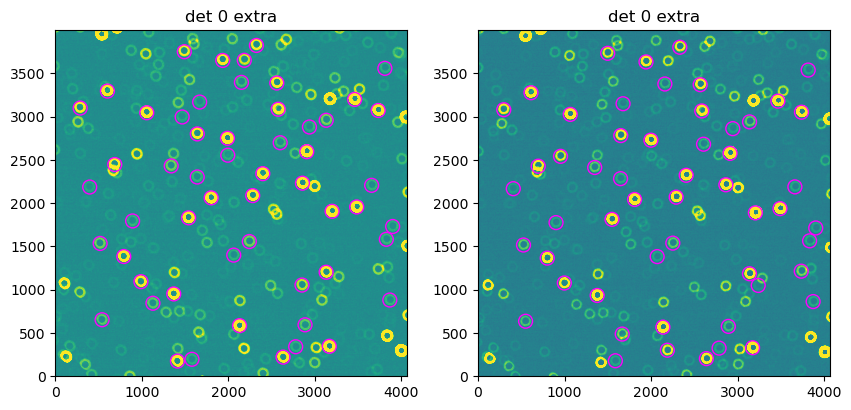

In [197]:
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,2,figsize=(10,5))
i=0
for exp, cat, title in zip([exp_intra, exp_extra], 
                                    [donutCatalogIntra, donutCatalogExtra], 
                                    ['intra', 'extra']
                                   ):
    d = exp.image.array
    vmin,vmax = zscale.get_limits(d)
    ax[i].imshow(d, vmin=vmin, vmax=vmax, origin='lower')
    
    ax[i].scatter(cat['centroid_x'], cat['centroid_y'], 
                marker='o', s=100, facecolors='none', edgecolors='magenta' 
                    )
    detId = refs[idx].dataId.detector.id
    ax[i].set_title(f'det {detId} extra')
    i +=1 

ok, so donuts got correctly detected. Do cutouts look ok?

Could do cutouts manually:

In [183]:
from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import (CutOutDonutsScienceSensorTask,
CutOutDonutsScienceSensorTaskConfig)
from lsst.obs.lsst import LsstComCam

camera = LsstComCam.getCamera()
config = CutOutDonutsScienceSensorTaskConfig()
task = CutOutDonutsScienceSensorTask(config=config)

In [201]:
exp_intra.visitInfo.focusZ

0.0

Both exposures have `visitInfo.focusZ` as `0.0` (!) So there's no way that this could work.... 

In [202]:
exp_intra.visitInfo.focusZ = -1.5
exp_extra.visitInfo.focusZ = 1.5

AttributeError: property of 'VisitInfo' object has no setter

In [198]:
taskOut = task.run([exp_intra, exp_extra],[donutCatalogIntra, donutCatalogExtra], camera)

ValueError: Must have one extra-focal and one intra-focal image.

No cutouts at all! Run a test with just 2 states:


pipetask run -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_direct_stamps_6001_test2  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDirectCutoutOnly.yaml -d "instrument='LSSTComCam' and exposure.seq_num = 6001" 


In [175]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutCatalog', 
           collections=['WET-001_lsstComCam_direct_stamps_6001_test2']).expanded()
for ref in dataRefs:
    print(ref)

donutCatalog@{instrument: 'LSSTComCam', detector: 0, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=1e855dee-7520-4651-949c-ec1f4503d070)
donutCatalog@{instrument: 'LSSTComCam', detector: 1, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=64235570-22fc-40a1-a757-b3b42e079bcc)
donutCatalog@{instrument: 'LSSTComCam', detector: 2, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=a287e722-3cc2-4acd-9f86-5cacffd6ae75)
donutCatalog@{instrument: 'LSSTComCam', detector: 3, visit: 5024072306001, band: 'r', day_obs: 20240723, physical_filter: 'r_03'} [sc=DataFrame] (run=WET-001_lsstComCam_direct_stamps_6001_test2/20241017T211540Z id=ccc62341-9270-4e3c-93a4-ad98fb

In [181]:
#butler.registry.queryDatasetTypes()

In [182]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutStampsIntra', 
           collections=['WET-001_lsstComCam_direct_stamps_6001_test2'],
                                        where=f"instrument='LSSTComCam'").expanded()
for ref in dataRefs:
    print(ref)

In [169]:
datarefs = butler.registry.queryDatasets('donutStampsIntra', 
                              collections=['WET-001_lsstComCam_direct_stamps_6001_6200'],
where=f"instrument='LSSTComCam'"
                             ).expanded()
refs = []
for ref in datarefs:
   refs.append(ref)

print(len(refs))

0


Nothing! How is that possible? 

In [162]:
donutStampsExtra= butler.get('donutStampsIntra',dataId=dataId, 
                             collections=['WET-001_lsstComCam_direct_stamps_6001_6200'])

DatasetNotFoundError: Dataset donutStampsIntra with data ID {instrument: 'LSSTComCam', detector: 0, visit: 5024072306002} could not be found in collections ['WET-001_lsstComCam_direct_stamps_6001_6200'].

In [ ]:
Run TIE and Danish us

In [ ]:
isrCollection =     "WET-001_lsstComCam_ISR"
cutoutsCollection = "WET-001_lsstComCam_direct_stamps"
tieCollection =     "WET-001_lsstComCam_direct_TIE"
danishCollection =  "WET-001_lsstComCam_direct_Danish"

isrYaml = "lsstComCamPipelineISR.yaml"
cutoutYaml = "lsstComCamPipelineDirectCutoutOnly.yaml"
danishYaml = "lsstComCamPipelineCalcDanishOnly.yaml"
tieYaml = "lsstComCamPipelineCalcTieOnly.yaml"

pathCwd = '/sdf/group/rubin/shared/scichris/DM-46763_WET-007'
isrYamlPath = os.path.join(pathCwd, isrYaml)
cutoutYamlPath = os.path.join(pathCwd, cutoutYaml)
danishYamlPath = os.path.join(pathCwd, danishYaml)
tieYamlPath = os.path.join(pathCwd, tieYaml)

cmdCutout = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {isrCollection},LSSTCam/calib/unbounded \
-o {cutoutsCollection}  -p {cutoutYamlPath}"

cmdDanish = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {danishCollection}  -p {danishYamlPath} "

cmdTie = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {tieCollection}  -p {tieYamlPath}"

print(cmdCutout, "\n")
print(cmdDanish, "\n")
print(cmdTie, "\n")
